Certainly! Below is the PyTorch code for a Variational Autoencoder (VAE) with a 2D latent space trained on the MNIST dataset using fully connected layers (no convolutional layers). The code includes:

- Device selection (GPU/MPS if available)
- Data loading with train/validation split
- VAE model definition with the reparameterization trick
- Separate loss function
- Model summary using `torchinfo.summary`
- Training loop with `tqdm` for progress display
- Plotting of the latent space
- Displaying original vs. reconstructed images
- Sampling and displaying new images from the latent space



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np


In [2]:
# Check if MPS (Apple Silicon) or CUDA (GPU) is available and use it if so
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
# device = torch.device("cpu")


Using device: mps


In [3]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-3
epochs = 10
latent_dim = 2
input_dim = 28 * 28  # MNIST image size

# Define transformations
transform = transforms.ToTensor()

# Load MNIST dataset
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Split dataset into training and validation sets (e.g., 80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Remove torch.set_default_device(device) and specify generator device if needed
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# VAE Model Definition
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # Added to use in forward method
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # Mean vector
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Log variance vector

        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn(std.size(), device=std.device)  # Corrected line
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


In [6]:
# Loss Function
def loss_function(x_reconstructed, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(
        x_reconstructed, x.view(-1, input_dim), reduction="sum"
    )
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [7]:
# Initialize model, optimizer
model = VAE(input_dim=input_dim, hidden_dim=400, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print model summary using torchinfo
print(summary(model, input_size=(batch_size, 1, 28, 28), device=str(device)))


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [128, 784]                --
├─Linear: 1-1                            [128, 400]                314,000
├─ReLU: 1-2                              [128, 400]                --
├─Linear: 1-3                            [128, 2]                  802
├─Linear: 1-4                            [128, 2]                  802
├─Linear: 1-5                            [128, 400]                1,200
├─ReLU: 1-6                              [128, 400]                --
├─Linear: 1-7                            [128, 784]                314,384
├─Sigmoid: 1-8                           [128, 784]                --
Total params: 631,188
Trainable params: 631,188
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 80.79
Input size (MB): 0.40
Forward/backward pass size (MB): 1.63
Params size (MB): 2.52
Estimated Total Size (MB): 4.55


In [8]:
# Training Loop
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    with tqdm(
        total=len(train_loader), desc=f"Epoch {epoch}/{epochs}", unit="batch"
    ) as pbar:
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item() / len(data)})
            pbar.update(1)
    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_train_loss:.4f}")


Epoch 1/10: 100%|██████████| 375/375 [00:03<00:00, 101.34batch/s, loss=180]


====> Epoch: 1 Average loss: 196.2218


Epoch 2/10: 100%|██████████| 375/375 [00:03<00:00, 119.25batch/s, loss=165]


====> Epoch: 2 Average loss: 169.3597


Epoch 3/10: 100%|██████████| 375/375 [00:03<00:00, 117.16batch/s, loss=161]


====> Epoch: 3 Average loss: 163.3904


Epoch 4/10: 100%|██████████| 375/375 [00:03<00:00, 116.89batch/s, loss=172]


====> Epoch: 4 Average loss: 160.6832


Epoch 5/10: 100%|██████████| 375/375 [00:03<00:00, 111.35batch/s, loss=158]


====> Epoch: 5 Average loss: 158.9734


Epoch 6/10: 100%|██████████| 375/375 [00:03<00:00, 106.89batch/s, loss=162]


====> Epoch: 6 Average loss: 157.6877


Epoch 7/10: 100%|██████████| 375/375 [00:03<00:00, 111.09batch/s, loss=160]


====> Epoch: 7 Average loss: 156.6283


Epoch 8/10: 100%|██████████| 375/375 [00:03<00:00, 115.21batch/s, loss=158]


====> Epoch: 8 Average loss: 155.7680


Epoch 9/10: 100%|██████████| 375/375 [00:03<00:00, 110.91batch/s, loss=152]


====> Epoch: 9 Average loss: 154.9721


Epoch 10/10: 100%|██████████| 375/375 [00:03<00:00, 117.18batch/s, loss=158]

====> Epoch: 10 Average loss: 154.4202


In [9]:
# Plotting the latent space (using validation data)
model.eval()
with torch.no_grad():
    mu_list = []
    labels_list = []
    for data, labels in val_loader:
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, input_dim))
        mu_list.append(mu.cpu())
        labels_list.append(labels)
    mu_all = torch.cat(mu_list)
    labels_all = torch.cat(labels_list)


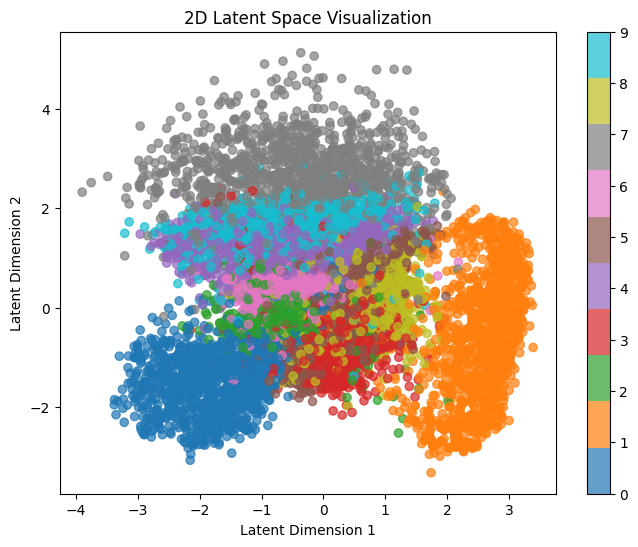

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(mu_all[:, 0], mu_all[:, 1], c=labels_all, cmap="tab10", alpha=0.7)
plt.colorbar()
plt.title("2D Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


In [11]:
# Display original images and their reconstructions
def show_images(original, reconstructed, num_images=8):
    original = original.view(-1, 1, 28, 28)
    reconstructed = reconstructed.view(-1, 1, 28, 28)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(original[i, 0].cpu(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i, 0].cpu().detach(), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()


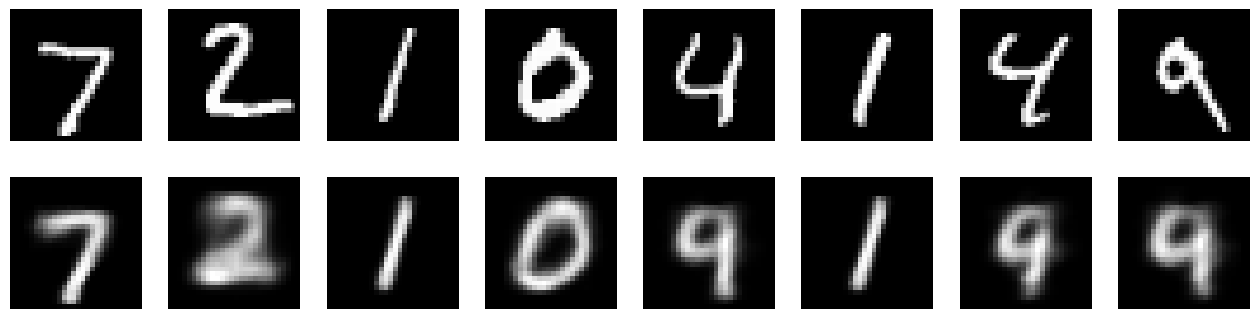

In [12]:
# Get a batch from test set
dataiter = iter(test_loader)
test_images, _ = next(dataiter)
test_images = test_images.to(device)
recon_images, _, _ = model(test_images)
show_images(test_images, recon_images)


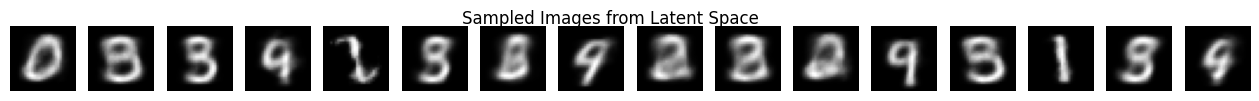

In [13]:
# Sample new images from the latent space
with torch.no_grad():
    z = torch.randn(
        16, latent_dim, device=device
    )  # Sample from standard normal on correct device
    sample = model.decode(z).cpu()
    sample = sample.view(-1, 1, 28, 28)

    # Plot sampled images
    fig, axes = plt.subplots(1, 16, figsize=(16, 1))
    for i in range(16):
        axes[i].imshow(sample[i, 0], cmap="gray")
        axes[i].axis("off")
    plt.suptitle("Sampled Images from Latent Space")
    plt.show()

In [ ]:

**Explanation:**

- **Device Selection:** The code checks for the availability of MPS (for Apple Silicon) or CUDA (GPU). If neither is available, it defaults to CPU.
  
- **Data Loading:** The MNIST dataset is loaded with transformations to convert images to tensors. It is split into training and validation sets (80% training, 20% validation).
  
- **VAE Model:** A class `VAE` is defined with fully connected layers for both the encoder and decoder. The encoder outputs the mean and log variance vectors for the latent space. The reparameterization trick is implemented in the `reparameterize` method.
  
- **Loss Function:** The loss function combines the Binary Cross-Entropy (BCE) for reconstruction loss and the Kullback-Leibler Divergence (KLD) for the latent space regularization.
  
- **Model Summary:** The `torchinfo.summary` function is used to print a summary of the model architecture.
  
- **Training Loop:** The model is trained using the Adam optimizer. The `tqdm` library is used to display a progress bar for each epoch, showing the loss per batch.
  
- **Latent Space Visualization:** After training, the model encodes the validation data to obtain the latent means (`mu`). These are plotted in a scatter plot with colors representing the actual digit labels.
  
- **Reconstruction Visualization:** A batch of test images and their reconstructions are displayed side by side for comparison.
  
- **Sampling New Images:** The model decodes randomly sampled latent vectors (from a standard normal distribution) to generate new images, which are displayed in a row.

**Notes:**

- The number of epochs is set to 10 for demonstration purposes. You can increase it to improve the model's performance.
- The batch size and learning rate are standard values but can be tuned for better results.
- The latent dimension is set to 2 to facilitate visualization of the latent space.
- The use of fully connected layers without convolutional layers simplifies the model but may affect the quality of the reconstructions compared to convolutional VAEs.

Feel free to run this code and adjust parameters as needed!